In [1]:
import os
sys.path.append("../")
import sys
from utilities.gcn_utills import *
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import networkx as nx
import glob
import pandas as pd
import scipy 
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.utils import convert
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler



/mnt/mnemo5/sum02dean/miniconda3/envs/gcn-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def read_graphs(file_set):
    g_list = []
    for i, file in enumerate(file_set):
        G = nx.read_gpickle(file)
        g_list.append(G)
    return g_list
    
def format_graphs(graphs, label=1):
    graph_list = []
    # Convert into pytorch geoetric dataset
    for i, x in enumerate(tqdm(graphs)):
        F = nx.convert_node_labels_to_integers(x)
        
        # nx default addition edge name - undesirbale
        att = 'weight' 
        for (n1, n2, d) in F.edges(data=True):
            if att in d:
                # To clear specific edge data
                d.pop(att, None) 

        data = convert.from_networkx(F, group_edge_attrs=['dca', 'proximity'])
        data.y = torch.FloatTensor(np.array([label]))
        graph_list.append(data)
    return graph_list

def binary_acc(y_pred, y_test):
    probas = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag, probas

In [3]:
# Import the data
graph_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/dca_graph_data'
labels_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/dca_graph_labels'

graph_files = glob.glob(os.path.join(graph_dir_path, '*'))
graph_labels = glob.glob(os.path.join(labels_dir_path, '*'))
graph_labels = pd.read_csv(graph_labels[0])

# Create positive and negative sets
positives = []
pos_labels = []

negatives = []
neg_labels = []

for i, file in enumerate(graph_files):
    obs, label = get_label(file, graph_labels)
    
    if label == 1:
        positives.append(obs)
        pos_labels.append([1,0])
    else:
        negatives.append(obs)
        neg_labels.append([0,1])


In [4]:
# Balance the number of negatives with number of positives
negatives = np.random.choice(negatives, size=len(positives), replace=False)

In [5]:
# Read in the positives
pos_graphs = read_graphs(positives)
neg_graphs = read_graphs(negatives)


In [6]:
# Format graphs
positive_graphs = format_graphs(pos_graphs, label=1)
negative_graphs = format_graphs(neg_graphs, label=0)

  0%|          | 0/5417 [00:00<?, ?it/s]/mnt/mnemo5/sum02dean/miniconda3/envs/gcn-env/lib/python3.9/site-packages/torch_geometric/utils/convert.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)
100%|██████████| 5417/5417 [09:51<00:00,  9.16it/s]  


In [7]:
# Make sure number of negative graphs equal number of positives graphs
assert(len(negative_graphs) == len(positive_graphs))

# # Combine negative and positive data
balanced_graphs = positive_graphs + negative_graphs

# # Sclaer
# ss = MinMaxScaler()
# train_x = np.vstack([d.x for d in balanced_graphs])
# train_x = pd.DataFrame(train_x)
# train_x = pd.DataFrame(ss.fit_transform(train_x))

# for i in range(len(balanced_graphs)):
#     balanced_graphs[i].x = torch.FloatTensor(ss.transform(balanced_graphs[i].x))


In [9]:
# Split into train and test
train_idx = np.random.choice(a=[False, True], size=len(balanced_graphs))
test_idx = ~train_idx

# Convert range to array 
full_idx = np.array(range(len(balanced_graphs)))

# Grab indices using Boolean array
tr_idx = full_idx[train_idx]
te_idx = full_idx[test_idx]

# Slice train and test data
train_data = [balanced_graphs[x] for x in tr_idx]
test_data = [balanced_graphs[x] for x in te_idx]



In [43]:
# Select appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=100, n_heads=1):
        super(GCN, self).__init__()

        # Parameters
        self.num_node_features = 16
        self.num_classes = 1
        self.hidden_channels = hidden_channels
        self.n_heads = n_heads

        # Layers (consider using class SAGEConv instead)
        self.conv1 = GATConv(self.num_node_features, self.hidden_channels, edge_dim=2, heads=n_heads)
        # self.linear_1 = Linear(self.hidden_channels * self.n_heads, self.hidden_channels)
        self.linear_2 = Linear(self.hidden_channels, self.num_classes)

        # Paramteric PRelU
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
        self.prelu_3 = torch.nn.PReLU()

        # Regularization
        p = 0.1
        self.drop_out = torch.nn.Dropout(p=p)

        # Batch Normalization
        self.batch_norm_1 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_2 = torch.nn.BatchNorm1d(num_features=self.hidden_channels, track_running_stats=False, momentum=None)
        self.batch_norm_3 = torch.nn.BatchNorm1d(num_features=self.num_classes, track_running_stats=False, momentum=None)

    def forward(self, x, edge_index, batch, edge_features):

        # 1.Conv block 1
        x = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_features)
        x = self.prelu_1(x)
        
        # Feature pooling
        x = global_mean_pool(x, batch)  # --> [batch_size, hidden_channels]

        # 3. Linearization
        # x = self.linear_1(x)
        # x = self.batch_norm_2(x)
        # x = self.prelu_2(x)

        # 4. Logic outputs
        x = self.linear_2(x)
        x = self.batch_norm_3(x)
        x = self.drop_out(x)
        x = self.prelu_2(x)
        return x


cpu


In [44]:
# Build model
model = GCN(hidden_channels=100, n_heads=1)
print(model)

GCN(
  (conv1): GATConv(16, 100, heads=1)
  (linear_2): Linear(in_features=100, out_features=1, bias=True)
  (prelu_1): PReLU(num_parameters=1)
  (prelu_2): PReLU(num_parameters=1)
  (prelu_3): PReLU(num_parameters=1)
  (drop_out): Dropout(p=0.1, inplace=False)
  (batch_norm_1): BatchNorm1d(100, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_2): BatchNorm1d(100, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
  (batch_norm_3): BatchNorm1d(1, eps=1e-05, momentum=None, affine=True, track_running_stats=False)
)


In [45]:
# Configs
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.0002

# Optimizers & Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()

# Data-loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
all_loader  = DataLoader(balanced_graphs, batch_size=BATCH_SIZE, shuffle=False)


In [46]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'checkpoint/best_model.pth')

In [48]:
# Train loop
print("Begining training!")
model.train()
dtype = torch.float
model = model.float()
n_obs = np.shape(balanced_graphs)[0]
update_every = 10
checkpoint = SaveBestModel()

for epoch in range(EPOCHS):
    running_loss = 0.0
    epoch_loss = 0.0
    epoch_losses = []
    test_losses = []


    with tqdm(total=n_obs // BATCH_SIZE) as pbar:
        for i, data in enumerate(train_loader): 

            # Grab data variables
            X, Y, EI, EA, B = data.x, data.y, data.edge_index, data.edge_attr, data.batch
            optimizer.zero_grad()  

            # Compute model outputs
            logits = model(X.type(dtype), EI, B, EA.type(dtype))
            probas = torch.sigmoid(logits.flatten())

            # Calculate loss
            loss = criterion(probas, Y)  
            epoch_loss += loss.item() 

            # Backwards + optimize
            loss.backward() 
            epoch_loss += logits.shape[0] * loss.item()
            running_loss += loss.item()
            optimizer.step()

            # Update progress bar
            pbar.update(1)
            if i % update_every == update_every - 1:
                pbar.set_description(f'Epoch {epoch + 1}/{EPOCHS}:  loss {running_loss / update_every:.3f}')
                running_loss = 0.0  

    # With torch loss
    with torch.no_grad():
        test_loss = 0.0

        for j, data in enumerate(test_loader):

                # Grab data variables
            X, Y, EI, EA, B = data.x, data.y, data.edge_index, data.edge_attr, data.batch
            optimizer.zero_grad()  

            # Compute model outputs
            logits = model(X.type(dtype), EI, B, EA.type(dtype))
            probas = torch.sigmoid(logits.flatten())
            
            loss = criterion(probas, Y)
            test_loss += logits.shape[0] * loss.item()

        # Save the best model
        print(epoch_losses, test_losses)
        test_losses.append(test_loss / n_obs)
        checkpoint(test_loss, epoch, model, optimizer, criterion)
    
    # Append epoch loss to list
    epoch_losses.append(epoch_loss / n_obs)
    test_losses.append(test_loss / n_obs)
    




Begining training!


Epoch 1/100:  loss 0.682:  51%|█████▏    | 111/216 [09:09<08:39,  4.95s/it]


[] []

Best validation loss: 3887.779278576374

Saving best model for epoch: 1



Epoch 2/100:  loss 0.676:  51%|█████▏    | 111/216 [09:09<08:40,  4.95s/it]


[] []

Best validation loss: 3876.7780342698097

Saving best model for epoch: 2



Epoch 3/100:  loss 0.678:  22%|██▏       | 48/216 [04:03<14:12,  5.08s/it]


KeyboardInterrupt: 

100%|██████████| 107/107 [00:19<00:00,  5.56it/s]


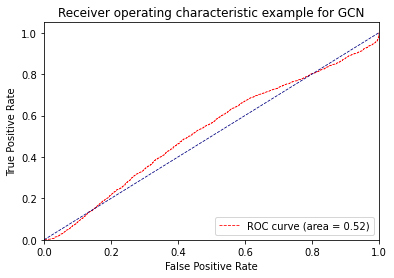

In [21]:
predictions = []
probabilities = []
truths = []

# Loadder names: train_loader, test_loader, all_loader
model.eval()
with torch.no_grad():
    for data in tqdm(test_loader): 
        
        # Grab inputs
        X, Y, EI, EA, B = data.x, data.y, data.edge_index, data.edge_attr, data.batch

        # Compute preds
        logits = model(X.type(dtype), EI, B, EA.type(dtype))
        acc, pred, probas = binary_acc(logits.flatten(), Y)

        # Append data
        predictions.append(pred)
        probabilities.append(probas)
        truths.append(Y)

# Format
p = np.hstack(predictions)
t = np.hstack(truths)
prob = np.array(torch.concat(probabilities))

# AUC/ROC
fpr, tpr, _ = roc_curve(t, prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
lw = 0.8
plt.plot(fpr, tpr, "r--", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example for GCN")
plt.legend(loc="lower right")
plt.show()
plt.show()
